In [2]:

import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from scipy.stats import norm, multivariate_normal
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

from scipy.spatial.transform import Rotation as R
from joblib import Parallel, dump, load, delayed

In [3]:
# DEPRECATED
# Generate a vector with specific cosine similarity to another vector
def generate_cosine_similar_vector(c, theta, random_state=None):
    """
    Generate a vector 'a' such that the cosine similarity between 'a' and 'c' is equal to theta.

    Parameters
    ----------
    c : np.ndarray
        Reference column vector.
    theta : float
        Desired cosine similarity (-1 to 1).

    Returns
    -------
    np.ndarray
        Vector 'a' with cosine similarity theta to 'c'.
    """
    rng = np.random.default_rng(random_state)
    ori_nrom = np.linalg.norm(c)
    # make c into a unit vector
    c = c / np.linalg.norm(c)
    # generate a random vector orthogonal to c
    d = rng.normal(size=c.shape)
    d -= d.dot(c) * c  # make orthogonal to c by subtracting the projection
    # normalize d to make it a unit vector
    d /= np.linalg.norm(d)

    # generate the vector a with the desired cosine similarity
    sin = np.sqrt(1 - theta**2)
    a = theta * c + sin * d
    return a * ori_nrom

# Example usage for cosine similarity
c = np.random.randn(100)
theta = 0.8
a = generate_cosine_similar_vector(c, theta)
actual_theta = np.dot(c, a) / (np.linalg.norm(c) * np.linalg.norm(a))
print(f"Target Cosine Similarity: {theta}, Actual: {actual_theta:.4f}")
np.linalg.norm(c)-np.linalg.norm(a)

Target Cosine Similarity: 0.8, Actual: 0.8000


0.0

# Zilu ver

In [4]:

unique_axislocs = np.array([-2,-1,1,2])
n_unique_axisloc = len(unique_axislocs)

stimlocs = list(itertools.product(unique_axislocs, unique_axislocs))
print(stimlocs)


[(-2, -2), (-2, -1), (-2, 1), (-2, 2), (-1, -2), (-1, -1), (-1, 1), (-1, 2), (1, -2), (1, -1), (1, 1), (1, 2), (2, -2), (2, -1), (2, 1), (2, 2)]


In [5]:
# Generate a vector with specific cosine similarity to another vector
def generate_remapped_vector(c, unique_locs, frac, invert=False,random_state=None):
    """
    Generate a vector 'a' such that the cosine similarity between 'a' and 'c' is equal to theta.

    Parameters
    ----------
    c : np.ndarray
        Reference column vector.
    theta : float
        Desired cosine similarity (-1 to 1).

    Returns
    -------
    np.ndarray
        Vector 'a' with cosine similarity theta to 'c'.
    """

    assert frac >=0
    assert frac<=1

    a = np.copy(c)
    
    rng = np.random.default_rng(random_state)
    
    # invert if assumed
    if invert:
        a = -a

    # select a subset to remap
    N_R= int(frac*len(c))
    R_indices = rng.choice(np.arange(len(c)), N_R, replace=False)

    # randomly choose new place field
    a[R_indices] = rng.choice(unique_locs, N_R, replace=True) + rng.normal(loc=0,scale=0.1,size=(N_R,))

    return a

# Example usage for cosine similarity
c = np.random.randn(100)
frac = 0.3
a = generate_remapped_vector(c, unique_axislocs,frac, invert=True)
actual_theta = np.dot(c, a) / (np.linalg.norm(c) * np.linalg.norm(a))
print(f"Remap Frac: {frac}, CosSim: {actual_theta:.4f}")

Remap Frac: 0.3, CosSim: -0.5089


In [6]:
axisloc_palhex = dict(zip(
    [-2,-1,1,2],
    ['#FFD300', '#005800', '#9E4F46', '#00FFC1'] 
))
colz = list(axisloc_palhex.values())
unique_axislocs = list(axisloc_palhex.keys())
n_unique_axisloc = len(axisloc_palhex)


In [7]:
def plot_neuron_responsefield(neuronidx, neuron_matrix,fig=None,ax=None):
    """
    Plot the response field of a neuron given its index and the neuron activity matrix.
    """
    fspace_x = np.linspace(-2.5,2.5, 100)
    fspace_y = np.linspace(-2.5,2.5, 100)
    var = 0.5

    fieldplot = []
    
    #for xy in range(len(neuron_matrix[0])):
    xy = neuron_matrix[neuronidx]
        
    # Create 2D Gaussian using outer product of two 1D Gaussians
    tmp = np.outer(norm.pdf(fspace_x, xy[0], var), norm.pdf(fspace_y, xy[1], var))

    # Zero out values below 50th percentile
    threshold = np.quantile(tmp, 0.5)
    tmp[tmp < threshold] = 0

    fieldplot.append(tmp)

    # Sum across all fields and display
    summed_plot = np.sum(fieldplot, axis=0)
    if ax is None:
        fig, ax = plt.subplots()
    img = ax.imshow(summed_plot, origin='lower')
    fig.colorbar(img,ax=ax)
    ax.set_title(f"Neuron {neuronidx} Response Field")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")


In [8]:
N = 500
rng = np.random.default_rng(42)
place_fields_x = rng.choice(unique_axislocs, size=N, replace=True)

frac = 0.3
place_fields_y = generate_remapped_vector(place_fields_x, unique_axislocs, frac, invert=True)

neuron_matrix = np.vstack([place_fields_x, place_fields_y]).T
print(neuron_matrix.shape)

stimlocs = list(itertools.product(unique_axislocs, unique_axislocs))
print(stimlocs)

activity = np.zeros((n_unique_axisloc,n_unique_axisloc, neuron_matrix.shape[0]))


(500, 2)
[(-2, -2), (-2, -1), (-2, 1), (-2, 2), (-1, -2), (-1, -1), (-1, 1), (-1, 2), (1, -2), (1, -1), (1, 1), (1, 2), (2, -2), (2, -1), (2, 1), (2, 2)]


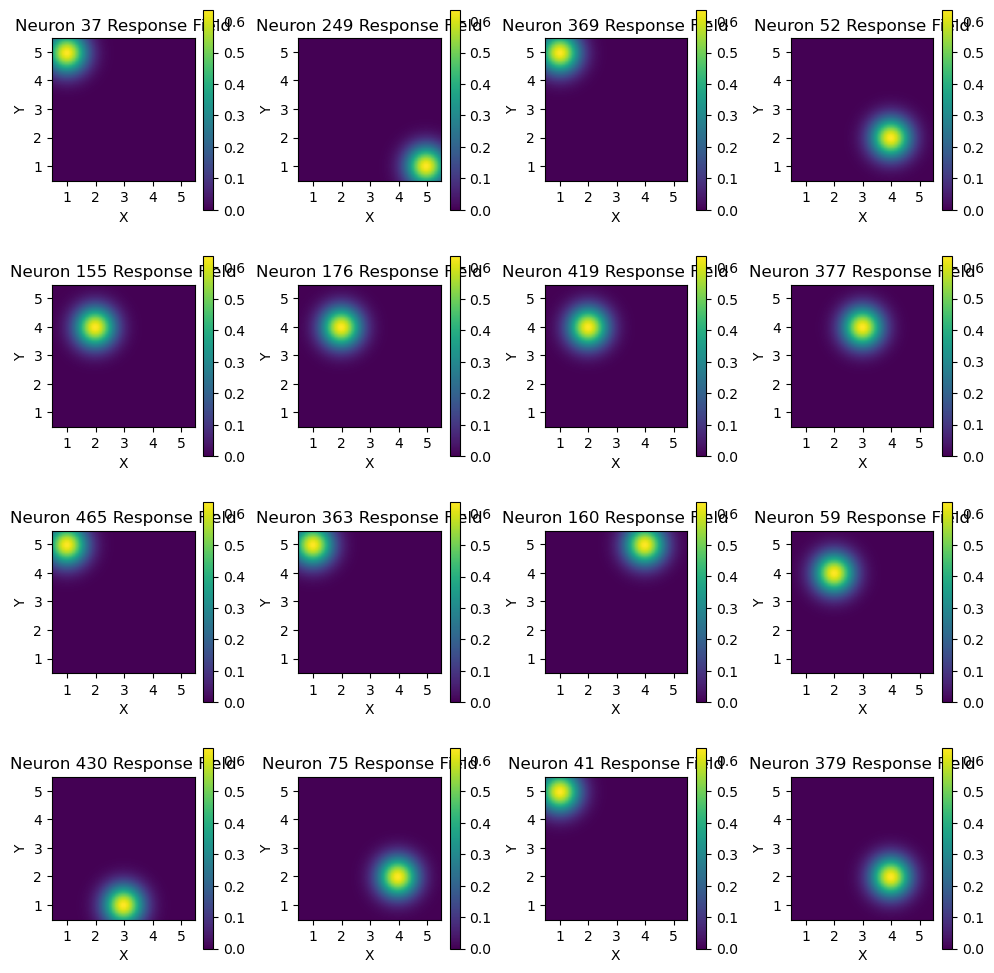

In [9]:
# plot example place fields
for idx_x,sx in enumerate(unique_axislocs):
    for idx_y,sy in enumerate(unique_axislocs):
        stimlocs[idx_x * n_unique_axisloc + idx_y] = [sx, sy]
        for n in range(neuron_matrix.shape[0]):
                activity[idx_x,idx_y, n] = multivariate_normal.pdf([sx, sy], mean=neuron_matrix[n], cov=[[0.5, 0], [0, 0.5]])


fig,axes = plt.subplots(4,4,figsize=(10, 10))
for k,ax in enumerate(axes.flatten()):
    plot_neuron_responsefield(np.random.randint(N), neuron_matrix,fig=fig,ax=ax)
    ax.set_xticks(np.linspace(10, 90, 5))
    ax.set_xticklabels(range(1, 6))
    ax.set_yticks(np.linspace(10, 90, 5))
    ax.set_yticklabels(range(1, 6))
fig.tight_layout()
plt.show()



c:\Users\liangz\miniconda3\envs\piratefmri\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


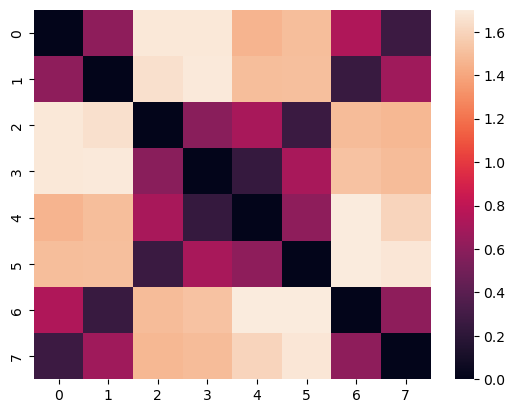

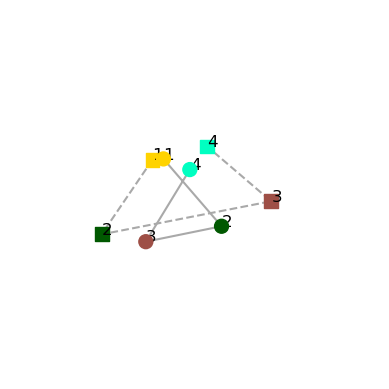

In [10]:
neural_activity_x = np.mean(activity, axis=1)
neural_activity_y = np.mean(activity, axis=0)

cos_x = pairwise_distances(neural_activity_x, metric='correlation')
cos_y = pairwise_distances(neural_activity_y, metric='correlation')

neural_activity_10 = np.vstack([neural_activity_x, neural_activity_y])

neural_rdm = pairwise_distances(neural_activity_10, metric='correlation')
mds = MDS(n_components=3, dissimilarity='precomputed').fit_transform(neural_rdm)

sns.heatmap(neural_rdm)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(mds[:n_unique_axisloc, 0], mds[:n_unique_axisloc, 1], mds[:n_unique_axisloc, 2], marker='o', facecolors=colz, edgecolors=None, s=100,alpha=1)
ax.plot3D(mds[:n_unique_axisloc, 0], mds[:n_unique_axisloc, 1], mds[:n_unique_axisloc, 2],'-', color='darkgrey')

ax.scatter(mds[n_unique_axisloc:, 0], mds[n_unique_axisloc:, 1], mds[n_unique_axisloc:, 2], marker='s', facecolors=colz, edgecolors=None, s=100,alpha=1)
ax.plot3D(mds[n_unique_axisloc:, 0], mds[n_unique_axisloc:, 1], mds[n_unique_axisloc:, 2], '--', color='darkgrey')
plt.axis('off')


for k in range(n_unique_axisloc):
    ax.text(*mds[k], str(k+1), fontsize=12)
    ax.text(*mds[k+n_unique_axisloc], str(k+1), fontsize=12)

plt.show()


In [11]:
# average over simulations
def generate_place_fields(N, unique_axislocs, theta, random_state=None):
    rng = np.random.default_rng(random_state)

    # generate random preference on one axis
    place_fields_x = rng.choice(unique_axislocs, size=N, replace=True)
    place_fields_x = place_fields_x + rng.normal(loc=0,scale=0.1,size=place_fields_x.shape) # add some noise

    # generate preference on another axis based on alignment(e.g no remap,anticorrelated,orthogonal)
    #place_fields_y = generate_cosine_similar_vector(place_fields_x, theta, random_state=random_state)
    place_fields_y = generate_remapped_vector(place_fields_x, unique_axislocs, 1-np.abs(theta), invert = theta<0, random_state=random_state)

    place_fields = np.vstack([place_fields_x, place_fields_y]).T
    
    return place_fields

def simulate_activity(unique_axislocs_x,unique_axislocs_y,place_fields,noise=0.1,rectify_ths=0,return_stimloc=False):
    N = place_fields.shape[0]
    activity = np.zeros((len(unique_axislocs_x),len(unique_axislocs_y), N))
    for idx_x,sx in enumerate(unique_axislocs_x):
        for idx_y,sy in enumerate(unique_axislocs_y):
            stimlocs[idx_x * n_unique_axisloc + idx_y] = [sx, sy]
            for n, xy in enumerate(place_fields):
                    activity[idx_x,idx_y, n] = multivariate_normal.pdf([sx, sy], mean=xy, cov=noise*np.eye(len(xy)))
    activity[activity < rectify_ths] = 0
    if return_stimloc:
        return activity, stimlocs
    else:
        return activity


#rs = random.randint(0,10000000)
#print(rs)
N = 100
n_sim =1
theta_lists = [-.8,0,0.8]
neural_PFs = dict(zip(theta_lists, [[] for _ in theta_lists]))
neural_activities = dict(zip(theta_lists, [[] for _ in theta_lists]))
neural_rdms = dict(zip(theta_lists, [[] for _ in theta_lists]))

with Parallel(n_jobs=10) as parallel:
    for j, theta in enumerate(theta_lists):
        neural_PFs[theta] = parallel(delayed(generate_place_fields)(N, unique_axislocs, theta, random_state=rs) for rs in range(n_sim))
        neural_activities[theta] = parallel(delayed(simulate_activity)(unique_axislocs,unique_axislocs,P,noise=0.1) for P in neural_PFs[theta])

        get_xy_rdm = lambda A: pairwise_distances(np.vstack([np.mean(A, axis=1), np.mean(A, axis=0)]), metric='correlation')
        
        neural_rdms[theta] = parallel(delayed(get_xy_rdm)(A) for A in neural_activities[theta])


In [12]:
unique_axislocs

[-2, -1, 1, 2]

In [13]:
rng.random(n_unique_axisloc)

array([0.65193103, 0.86749063, 0.45389688, 0.24783956])

[-2, -1, 1, 2]


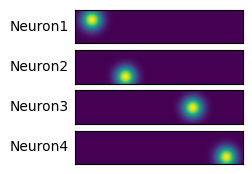

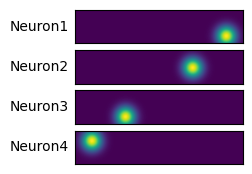

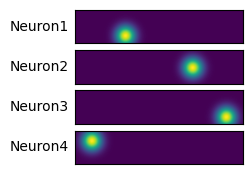

In [72]:
# Part 1: Heatmap of 2D place fields
print(unique_axislocs)
xx = np.arange(-.55, .45, 0.005) # width of the track
yy = np.arange(np.min(unique_axislocs)-.5, np.max(unique_axislocs)+.5, 0.01) # length of the track

rng = np.random.default_rng(123789)
fields_y = np.array(unique_axislocs) # preferred location on the linear track
fields_x = rng.random(n_unique_axisloc) * (xx.max() - xx.min()) + xx.min()+.001 # randomly sample preferred location along the width

#tmp = np.zeros((len(xx), len(yy)))
#for f in range(n_unique_axisloc):
#    tmp += np.outer(norm.pdf(xx, fields_x[f], .2), norm.pdf(yy, fields_y[f], .2))
fig, axes = plt.subplots(n_unique_axisloc,1,figsize=(6, 2))
for f,ax in enumerate(axes):
    tmp = np.outer(norm.pdf(xx, fields_x[f], .2), norm.pdf(yy, fields_y[f], .2))

    ax.imshow(tmp, extent=(yy.min(), yy.max(),xx.min(), xx.max()), origin='lower')
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f"Neuron{f+1}",rotation=0,ha="right",va="center")

plt.show()


fig, axes = plt.subplots(n_unique_axisloc,1,figsize=(6, 2))
for f,ax in enumerate(axes):
    tmp = np.outer(norm.pdf(xx, fields_x[int(3-f)], .2), norm.pdf(yy, fields_y[int(3-f)], .2))

    ax.imshow(tmp, extent=(yy.min(), yy.max(),xx.min(), xx.max()), origin='lower')
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f"Neuron{f+1}",rotation=0,ha="right",va="center")

plt.show()

random_shuffle_loc = np.random.default_rng(139).permutation(list(range(n_unique_axisloc)))
fig, axes = plt.subplots(n_unique_axisloc,1,figsize=(6, 2))
for f,ax in enumerate(axes):
    tmp = np.outer(norm.pdf(xx, fields_x[random_shuffle_loc[f]], .2), norm.pdf(yy, fields_y[random_shuffle_loc[f]], .2))
    ax.imshow(tmp, extent=(yy.min(), yy.max(),xx.min(), xx.max()), origin='lower')
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f"Neuron{f+1}",rotation=0,ha="right",va="center")
    
plt.show()



In [91]:
fields_x

array([-2.19016353, -2.14227418, -2.12776802, -2.1184118 , -2.07583698,
       -2.07354833, -2.06331941, -2.0617907 , -2.04327858, -2.03775635,
       -2.01089147, -1.97502146, -1.96172428, -1.96048779, -1.95701363,
       -1.94188342, -1.93039573, -1.906495  , -1.84255917, -1.14267739,
       -1.13412197, -1.12883615, -1.10298044, -1.08037318, -1.07546058,
       -1.07130681, -1.02873877, -1.01642946, -0.9947971 , -0.99244064,
       -0.97978856, -0.966038  , -0.96413281, -0.96287726, -0.93435251,
       -0.92124118, -0.91559213, -0.9010287 , -0.88498344, -0.87713163,
       -0.87054412, -0.86775425, -0.83108925, -0.81779886,  0.85984798,
        0.87916814,  0.89569989,  0.9338472 ,  0.94144712,  0.94314505,
        0.95040893,  0.95635648,  0.96410867,  0.97414275,  0.98649549,
        0.99242985,  0.99860853,  0.99955459,  1.01092797,  1.01610096,
        1.02684171,  1.03194142,  1.03863696,  1.06210179,  1.06304115,
        1.06333526,  1.07260938,  1.10039616,  1.10314531,  1.10

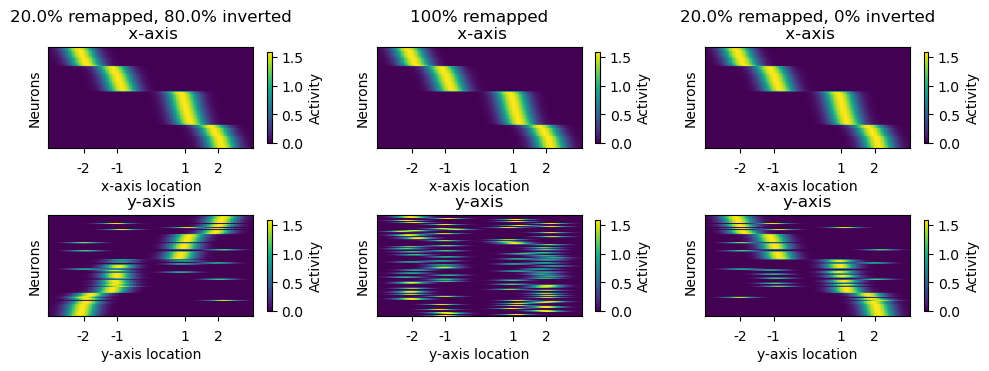

In [50]:
# Part 2: Heatmap of place fields on two linear tracks

linprog = np.arange(-3, 3.1, 0.1)
zz = np.vstack([linprog,np.ones_like(linprog)*0]).T
rng = np.random.default_rng(123789)
pick_rs = rng.choice(range(n_sim),1,replace=False)[0]

fig_activity, axes_activity = plt.subplots(2,3,figsize=(12,4))

for j_pcol, theta in enumerate(theta_lists):
    ax_xtrack = axes_activity[0,j_pcol]
    ax_ytrack = axes_activity[1,j_pcol]

    # we sort neurons by the x-coordinate of their place fields 
    sort_byx_ = np.argsort(neural_PFs[theta][pick_rs][:, 0])

    # initialize place holder for storing activity
    Ax = np.zeros((len(linprog),N))
    Ay = np.zeros((len(linprog),N))

    fields_x = neural_PFs[theta][pick_rs][sort_byx_, 0]
    fields_y = neural_PFs[theta][pick_rs][sort_byx_, 1]


    for kcol,(fx,fy) in enumerate(zip(fields_x,fields_y)):
        Ax[:,kcol] =  multivariate_normal.pdf(zz, mean=[fx,0], cov=0.1*np.eye(2))
        Ay[:,kcol] =  multivariate_normal.pdf(zz, mean=[fy,0], cov=0.1*np.eye(2))


    imx = ax_xtrack.imshow(Ax.T)#, extent=(zz.min(), zz.max(), linprog.min(), linprog.max()),origin='lower')
    imy = ax_ytrack.imshow(Ay.T)
    cbx=fig.colorbar(imx,ax=ax_xtrack,shrink=0.65,fraction=0.2)
    cby=fig.colorbar(imy,ax=ax_ytrack,shrink=0.65,fraction=0.2)
    cbx.set_label('Activity')
    cby.set_label('Activity')

    

    if theta<0:
        ax_xtrack.set_title(f"{np.round(1-np.abs(theta),2)*100}% remapped, {100-np.round(1-np.abs(theta),2)*100}% inverted\n x-axis",fontsize=12)
    else:
        if theta==0:
            ax_xtrack.set_title(f"100% remapped\n x-axis",fontsize=12)
        else:
            ax_xtrack.set_title(f"{np.round(1-np.abs(theta),2)*100}% remapped, 0% inverted\n x-axis",fontsize=12)
    
    ax_ytrack.set_title(f"y-axis",fontsize=12)
    ax_xtrack.set_xlabel("x-axis location",labelpad=3)
    ax_ytrack.set_xlabel("y-axis location",labelpad=3)

for ax in axes_activity.flatten():
    ax.set_aspect(0.3)
    #ax.axis('off')
    
    xtickloc=[np.where(np.abs(linprog-x)==np.min(np.abs(linprog-x)))[0][0] for x in unique_axislocs]
    ax.set_xticks(xtickloc, labels=unique_axislocs)
    ax.tick_params(axis='x',pad=6)
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

    ax.set_yticks([])
    ax.set_ylabel("Neurons",labelpad=5)
    

fig.tight_layout()    
plt.show()



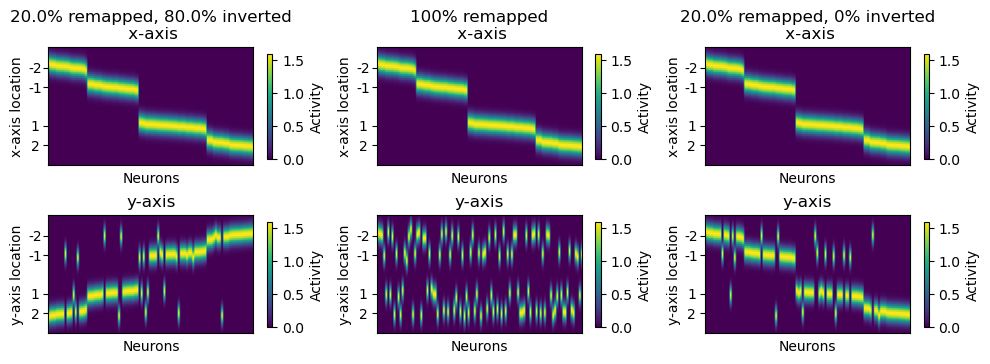

In [124]:
# Part 2: Heatmap of place fields on two linear tracks

linprog = np.arange(-3, 3.1, 0.1)
zz = np.vstack([linprog,np.ones_like(linprog)*0]).T
rng = np.random.default_rng(123789)
pick_rs = rng.choice(range(n_sim),1,replace=False)[0]

fig_activity, axes_activity = plt.subplots(2,3,figsize=(12,4))

for j_pcol, theta in enumerate(theta_lists):
    ax_xtrack = axes_activity[0,j_pcol]
    ax_ytrack = axes_activity[1,j_pcol]

    # we sort neurons by the x-coordinate of their place fields 
    sort_byx_ = np.argsort(neural_PFs[theta][pick_rs][:, 0])

    # initialize place holder for storing activity
    Ax = np.zeros((len(linprog),N))
    Ay = np.zeros((len(linprog),N))

    fields_x = neural_PFs[theta][pick_rs][sort_byx_, 0]
    fields_y = neural_PFs[theta][pick_rs][sort_byx_, 1]


    for kcol,(fx,fy) in enumerate(zip(fields_x,fields_y)):
        Ax[:,kcol] =  multivariate_normal.pdf(zz, mean=[fx,0], cov=0.1*np.eye(2))
        Ay[:,kcol] =  multivariate_normal.pdf(zz, mean=[fy,0], cov=0.1*np.eye(2))


    imx = ax_xtrack.imshow(Ax)#, extent=(zz.min(), zz.max(), linprog.min(), linprog.max()),origin='lower')
    imy = ax_ytrack.imshow(Ay)
    cbx=fig.colorbar(imx,ax=ax_xtrack,shrink=0.75,fraction=0.2)
    cby=fig.colorbar(imy,ax=ax_ytrack,shrink=0.75,fraction=0.2)
    cbx.set_label('Activity')
    cby.set_label('Activity')

    

    if theta<0:
        ax_xtrack.set_title(f"{np.round(1-np.abs(theta),2)*100}% remapped, {100-np.round(1-np.abs(theta),2)*100}% inverted\n x-axis",fontsize=12)
    else:
        if theta==0:
            ax_xtrack.set_title(f"100% remapped\n x-axis",fontsize=12)
        else:
            ax_xtrack.set_title(f"{np.round(1-np.abs(theta),2)*100}% remapped, 0% inverted\n x-axis",fontsize=12)
    
    ax_ytrack.set_title(f"y-axis",fontsize=12)
    ax_xtrack.set_ylabel("x-axis location",labelpad=3)
    ax_ytrack.set_ylabel("y-axis location",labelpad=3)

for ax in axes_activity.flatten():
    ax.set_aspect(0.94)
    #ax.axis('off')
    
    ytickloc=[np.where(np.abs(linprog-x)==np.min(np.abs(linprog-x)))[0][0] for x in unique_axislocs]
    ax.set_yticks(ytickloc, labels=unique_axislocs)
    ax.tick_params(axis='y',pad=6)
    plt.setp(ax.get_yticklabels(), rotation=0, ha='center')

    ax.set_xticks([])
    ax.set_xlabel("Neurons",labelpad=5)
    

fig.tight_layout()    
plt.show()



In [63]:
choose_color_from = sns.color_palette("colorblind",10).as_hex()

print(choose_color_from)
choose_color_from
psgroup_huedict = dict(zip(["top-right","orthogonal","top-left"],
                           #["#15B01A","#BF9000","#030764"],# GREEN, yellow, darkblue
                           [choose_color_from[5],choose_color_from[7],choose_color_from[8]]
                           )) 

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


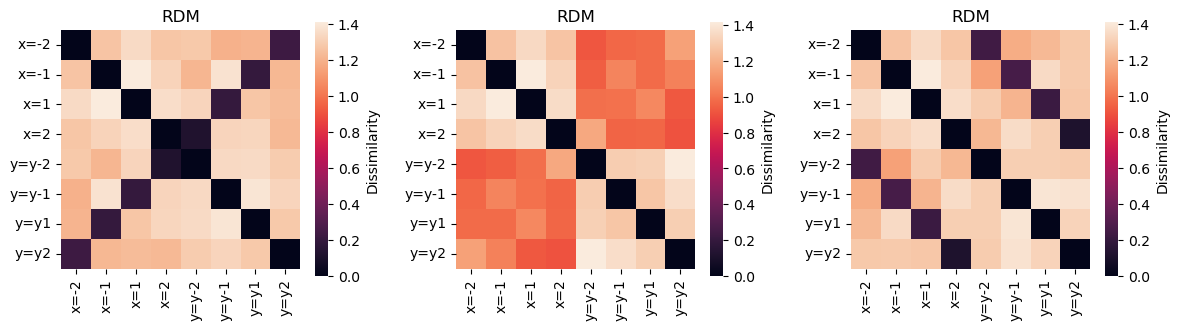

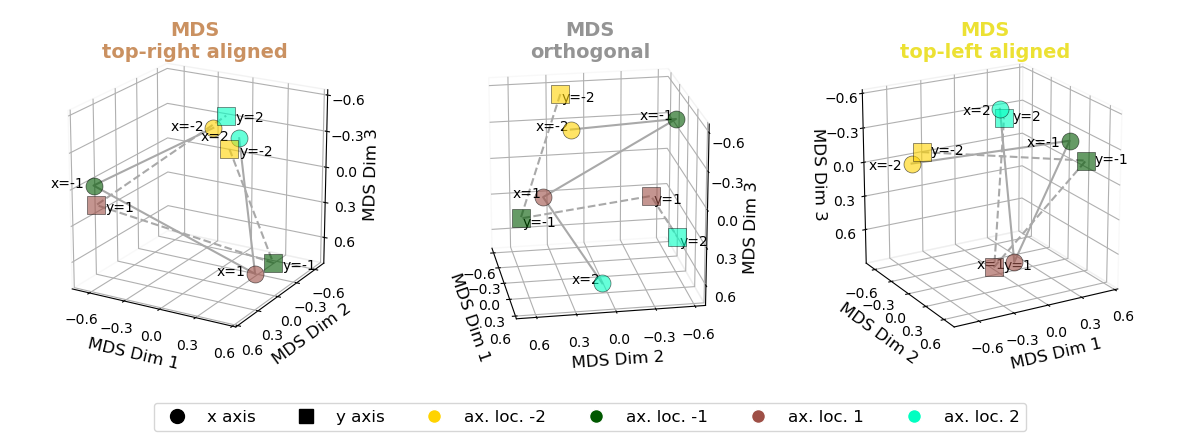

In [73]:
#

theta_viewpoints = dict(zip(theta_lists,
        [[-20,60,180],
         [-20,10,180],
         [-20,120,180]]))

mdstitles=dict(zip(theta_lists,
        ["MDS\ntop-right aligned",
         "MDS\northogonal",
         "MDS\ntop-left aligned"]))    
fig_rdm = plt.figure(figsize=(12,4))
fig_mds = plt.figure(figsize=(12,4))

for k, theta in enumerate(theta_lists):
    ax1 = fig_rdm.add_subplot(1,len(theta_lists),k+1)
    meanrdm = np.mean(neural_rdms[theta], axis=0)
    sns.heatmap(meanrdm, ax=ax1,square=True,
                cbar_kws={"shrink": .7,"label":"Dissimilarity"},
                xticklabels=[f"x={x}" for x in unique_axislocs]+[f"y=y{y}" for y in unique_axislocs],
                yticklabels=[f"x={x}" for x in unique_axislocs]+[f"y=y{y}" for y in unique_axislocs]
                )
    #ax1.set_title(f'fraction={np.round(1-np.abs(theta),2)*100}%, inverted={theta<0}\n RDM')
    ax1.set_title(f'RDM',fontsize=12)
    plt.setp(ax1.get_yticklabels(),rotation=0)
    plt.setp(ax1.get_xticklabels(),rotation=90)
       

    ax2 = fig_mds.add_subplot(1,len(theta_lists),k+1, projection='3d')
    mds = MDS(n_components=3, dissimilarity='precomputed',normalized_stress='auto',random_state=1).fit_transform(meanrdm)
    mds_df = pd.DataFrame(mds,columns=["MDS1","MDS2","MDS3"])
    mds_df["training_axes"] = ["x"]* n_unique_axisloc+["y"]* n_unique_axisloc 
    mds_df["axloc"] = unique_axislocs * 2

    for (ta, tl), group in mds_df.groupby(['training_axes', 'axloc']):
        ax2.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
                color=axisloc_palhex[tl], marker={"x":"o","y":"s"}[ta],
                s=150,edgecolor='black',linewidth=0.5,
                label=f'{ta},{tl}',alpha=0.6,zorder=2)
        if ta == "y":
            ax2.text(group['MDS1'].values[0]+0.08, group['MDS2'].values[0], group['MDS3'].values[0],s=f"{ta}={int(tl)}",ha="left",va="center",zorder=3)
        else:
            ax2.text(group['MDS1'].values[0]-0.08, group['MDS2'].values[0], group['MDS3'].values[0],s=f"{ta}={int(tl)}",ha="right",va="center",zorder=3)
        
    #ax2.scatter(data=mds_df,x="m1",y="m2",z="m3",marker="training_axes",color="axloc")
    #ax2.scatter(mds[:n_unique_axisloc, 0], mds[:n_unique_axisloc, 1], mds[:n_unique_axisloc, 2], marker='o', facecolors=colz, edgecolors=None, s=100,alpha=0.8)
    ax2.plot3D(mds[:n_unique_axisloc, 0], mds[:n_unique_axisloc, 1], mds[:n_unique_axisloc, 2],'-', color='darkgrey')

    #ax2.scatter(mds[n_unique_axisloc:, 0], mds[n_unique_axisloc:, 1], mds[n_unique_axisloc:, 2], marker='s', facecolors=colz, edgecolors=None, s=100,alpha=0.8)
    ax2.plot3D(mds[n_unique_axisloc:, 0], mds[n_unique_axisloc:, 1], mds[n_unique_axisloc:, 2], '--', color='darkgrey')

    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    alignment = mdstitles[theta].replace("MDS\n","").replace(" aligned","")
    ax2.set_title(mdstitles[theta],y=.92,fontsize=14,color=psgroup_huedict[alignment],fontweight="bold")
    ax2.set_xlabel('MDS Dim 1',fontdict={"size":12},labelpad=5)
    ax2.set_ylabel('MDS Dim 2',fontdict={"size":12},labelpad=5)
    ax2.set_zlabel('MDS Dim 3',fontdict={"size":12},labelpad=5)
#plt.axis('off')
    ticks = [-.6,-0.3,0,0.3,.6]
    ax2.set_xticks(ticks)
    ax2.set_yticks(ticks)
    ax2.set_zticks(ticks)
    ax2.set_box_aspect([1,1,1],zoom=.85)

    ax2.view_init(*theta_viewpoints[theta])
    #for k in range(n_unique_axisloc):
    #    ax2.text(*mds[k], str(k+1), fontsize=12, ha="left",va="bottom",fontweight="bold")
    #    ax2.text(*mds[k+n_unique_axisloc], str(k+1), fontsize=12, ha="left",va="bottom",fontweight="bold")

    # Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=axisloc_palhex[i], markersize=10, label='ax. loc. %d'%(i))
                for i in np.sort(mds_df["axloc"].unique())]
marker_legend = [plt.Line2D([0], [0], marker={"x":"o","y":"s"}[i], color='k', markerfacecolor='k',linewidth=0, markersize=10, label='%s axis'%(i)) 
                for i in np.sort(mds_df["training_axes"].unique())]
fig_mds.legend(handles=marker_legend + color_legend, loc='upper center', 
           bbox_to_anchor=(0.5, 0.),fontsize=12,
           ncol=6)

fig_rdm.tight_layout()
fig_mds.tight_layout()

plt.show()

In [ ]:
def generate_neuron_covariance(n1, n2, within_corr=0.1, between_corr=0.5):
    """
    Generate a covariance matrix for two neuron populations with controlled within- and between-population correlation.

    Parameters
    ----------
    n1 : int
        Number of neurons in population 1.
    n2 : int
        Number of neurons in population 2.
    within_corr : float
        Correlation within each population.
    between_corr : float
        Correlation between the two populations.

    Returns
    -------
    np.ndarray
        A (n1 + n2, n1 + n2) covariance matrix.
    """
    if not (-1 <= within_corr <= 1):
        raise ValueError("within_corr must be between -1 and 1.")
    if not (-1 <= between_corr <= 1):
        raise ValueError("between_corr must be between -1 and 1.")

    # Construct blocks
    block_within_1 = np.full((n1, n1), within_corr)
    block_within_2 = np.full((n2, n2), within_corr)
    np.fill_diagonal(block_within_1, 1.0)
    np.fill_diagonal(block_within_2, 1.0)

    block_between = np.full((n1, n2), between_corr)

    # Combine blocks into full covariance matrix
    top = np.hstack([block_within_1, block_between])
    bottom = np.hstack([block_between.T, block_within_2])
    cov = np.vstack([top, bottom])

    # Ensure positive semidefiniteness using eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvals[eigvals < 0] = 0  # Clamp negative eigenvalues
    cov_psd = eigvecs @ np.diag(eigvals) @ eigvecs.T

    return cov_psd


In [155]:
def make_neuron_activity(n1,n2,corr,discrete_locs,random_state=None):
    """
    Generate a matrix of neuron activity with specified correlation.

    Parameters
    ----------
    n1 : int
        Number of neurons in the first group.
    n2 : int
        Number of neurons in the second group.
    corr : float
        the level of correlation between neurons from different population

    Returns
    -------
    np.ndarray
        A matrix of shape (n1, n2) where each entry contains a random value
        drawn from a normal distribution with specified correlation.
    """
    # get the range of the linear tracks,
    # axis locations in the task only take some unique values, 
    # here we make it continuous
    # we extend the range by 0.5 to ensure the place fields are not too close to the edges
    locrang = np.min(discrete_locs)-.5, np.max(discrete_locs)+.5
    arena_x = np.linspace(locrang[0], locrang[1], 100)
    arena_y = np.linspace(locrang[0], locrang[1], 100)

    # randomly generate place fields for each neuron
    rng = np.random.default_rng(random_state)
    pf1 = rng.uniform(locrang[0], locrang[1], n1)
    pf2 = rng.uniform(locrang[0], locrang[1], n2)


    if not (-1 <= corr <= 1):
        raise ValueError("Correlation must be between -1 and 1.")

    mean = np.concatenate([pf1,pf2])
    within = 0.1 # the level of correlation between neurons in the same population
    cov = generate_neuron_covariance(n1, n2, within_corr=within, between_corr=corr)
    
    is_symmetric = np.allclose(cov, cov.T)
    print("Symmetric?", is_symmetric)

    eigenvalues = np.linalg.eigvalsh(cov)  # For symmetric matrices
    is_psd = np.all(eigenvalues >= 0)
    print("Symmetric PSD?", is_psd)  # Output: True



    

    
    return multivariate_normal.rvs(mean=mean, cov=cov), mean, cov

In [156]:
n1,n2 = 3,4
withincorr=0.1
corr=0.8
discrete_locs = [-2,-1,1,2]
neuronmat, neuronpf,popcov = make_neuron_activity(n1,n2,corr,discrete_locs,random_state=1)

Symmetric? True
Symmetric PSD? True


In [161]:
neuronmat.shape

(7,)

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(6,3))
# plot the covariance matrix
sns.heatmap(popcov,
            ax=axes[0],
            square=True
            )
# plot the empirical correlation matrix
sns.heatmap(np.corrcoef(neuronmat, rowvar=False),
            ax=axes[1],
            square=True
            
)


# Chris Ver

In [175]:
def make_neuron_activity(neurons, pf, randfract, linker, frame_switch,n_uloc,random_state= None):
    """Generate a matrix of neuron activity based on specified parameters.

    Parameters
    ----------
    neurons : int
        number of neurons to simulate.
    pf : int
        number of places
    randfract : _type_
        level of correlation between neurons, this is the noise term
    linker : _type_
        defines the correspondence between x and y preference
    frame_switch : _type_
        _description_

    Returns
    -------
    3D array
        A matrix of shape (neurons, pf, 2) where each entry contains a
        _description_
    """
    rng = np.random.default_rng(random_state)
    # Initialize the neuron activity matrix
    neuron_matrix = [[None for _ in range(pf)] for _ in range(neurons)]

    for n in range(neurons):
        # select a random place for the 
        select = rng.integers(0, n_uloc-1)  # 0-indexed for Python

        for f in range(pf):
            if rng.random() < randfract:
                neuron_matrix[n][f] = [rng.integers(1, n_uloc), rng.integers(1, n_uloc)] # neurons that prefer independent loc on x and y
            else: # neurons that with x-y preference correlated in someway as defined by linker
                if rng.random() < 0.5:
                    neuron_matrix[n][f] = [linker[frame_switch][select][0], rng.integers(1, n_uloc)]
                else:
                    neuron_matrix[n][f] = [rng.integers(1, n_uloc), linker[frame_switch][select][1]]

    return neuron_matrix

In [170]:


def plot_neuron_responsefield(neuronidx, neuron_matrix,fig=None,ax=None):
    """
    Plot the response field of a neuron given its index and the neuron activity matrix.
    """
    fspace_x = np.linspace(0.5, 5.5, 100)
    fspace_y = np.linspace(0.5, 5.5, 100)
    var = 0.5

    fieldplot = []

    for f in range(len(neuron_matrix[0])):
        xy = neuron_matrix[neuronidx][f]
        
        # Create 2D Gaussian using outer product of two 1D Gaussians
        tmp = np.outer(norm.pdf(fspace_x, xy[0], var), norm.pdf(fspace_y, xy[1], var))

        # Zero out values below 50th percentile
        threshold = np.quantile(tmp, 0.5)
        tmp[tmp < threshold] = 0

        fieldplot.append(tmp)

    # Sum across all fields and display
    summed_plot = np.sum(fieldplot, axis=0)
    if ax is None:
        fig, ax = plt.subplots()
    img = ax.imshow(summed_plot, origin='lower')
    fig.colorbar(img,ax=ax)
    ax.set_title(f"Neuron {neuronidx} Response Field")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")


In [48]:
# Helper function to squelch ndgrid equivalent
def squelch(arr):
    return arr.reshape(-1, 1)

# 3D rotation placeholder
def rotate3line(coords, angles):
    r = R.from_euler('zyx', angles, degrees=True)    
    return r.apply(coords)

In [192]:
axisloc_palhex = dict(zip(
    [-2,-1,1,2],
    ['#FFD300', '#005800', '#9E4F46', '#00FFC1'] 
))
unique_axislocs = list(axisloc_palhex.keys())
n_unique_axisloc = len(axisloc_palhex)


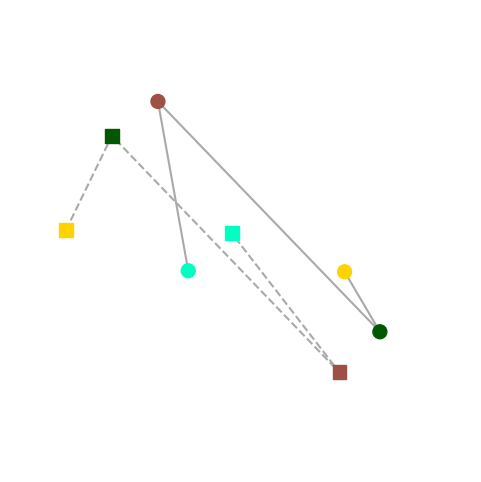

In [193]:
# Part 1: 3D plot with rotation
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

colz = list(axisloc_palhex.values()) #,'b'

#set random seed for reproducibility
rng = np.random.default_rng(123789)
xx = rng.integers(1, 6, (n_unique_axisloc, 1)) - 2.5
yy = rng.integers(1, 6, (n_unique_axisloc, 1)) - 2.5
zz = rng.integers(1, 6, (n_unique_axisloc, 1)) - 2.5

#xx = np.array([[1,2,4,5]]).T - 3
#yy = np.array([[0,0,2,2]]).T - 3
#zz = np.array([[1,2,4,5]]).T - 3

newmat = rotate3line(np.hstack([xx, yy, zz]), [90]*3)

xx2, yy2, zz2 = newmat[:, 0], newmat[:, 1], newmat[:, 2]

ax.scatter(xx.flatten(), yy.flatten(), zz.flatten(), marker='o', facecolors=colz, edgecolors=None, s=100,alpha=1)
ax.plot3D(xx.flatten(), yy.flatten(), zz.flatten(),'-', color='darkgrey')

ax.scatter(xx2, yy2, zz2, marker='s', facecolors=colz, edgecolors=None, s=100,alpha=1)
ax.plot3D(xx2, yy2, zz2, '--', color='darkgrey')
plt.axis('off')
plt.show()



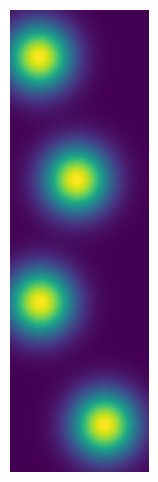

In [99]:
# Part 2: Heatmap of 2D place fields
fig, ax = plt.subplots(figsize=(2, 6))
xx = np.arange(-3, 3.1, 0.1)
yy = np.arange(-10, 10.1, 0.1)

rng = np.random.default_rng(123789)
fields_x = rng.random(n_unique_axisloc) * (xx.max() - xx.min()) + xx.min()
fields_y = np.linspace(-8, 8, n_unique_axisloc)

tmp = np.zeros((len(xx), len(yy)))
for f in range(n_unique_axisloc):
    tmp += np.outer(norm.pdf(xx, fields_x[f], 1), norm.pdf(yy, fields_y[f], 1))

ax.imshow(tmp.T, extent=(xx.min(), xx.max(), yy.min(), yy.max()), origin='lower')
ax.axis('off')
plt.show()



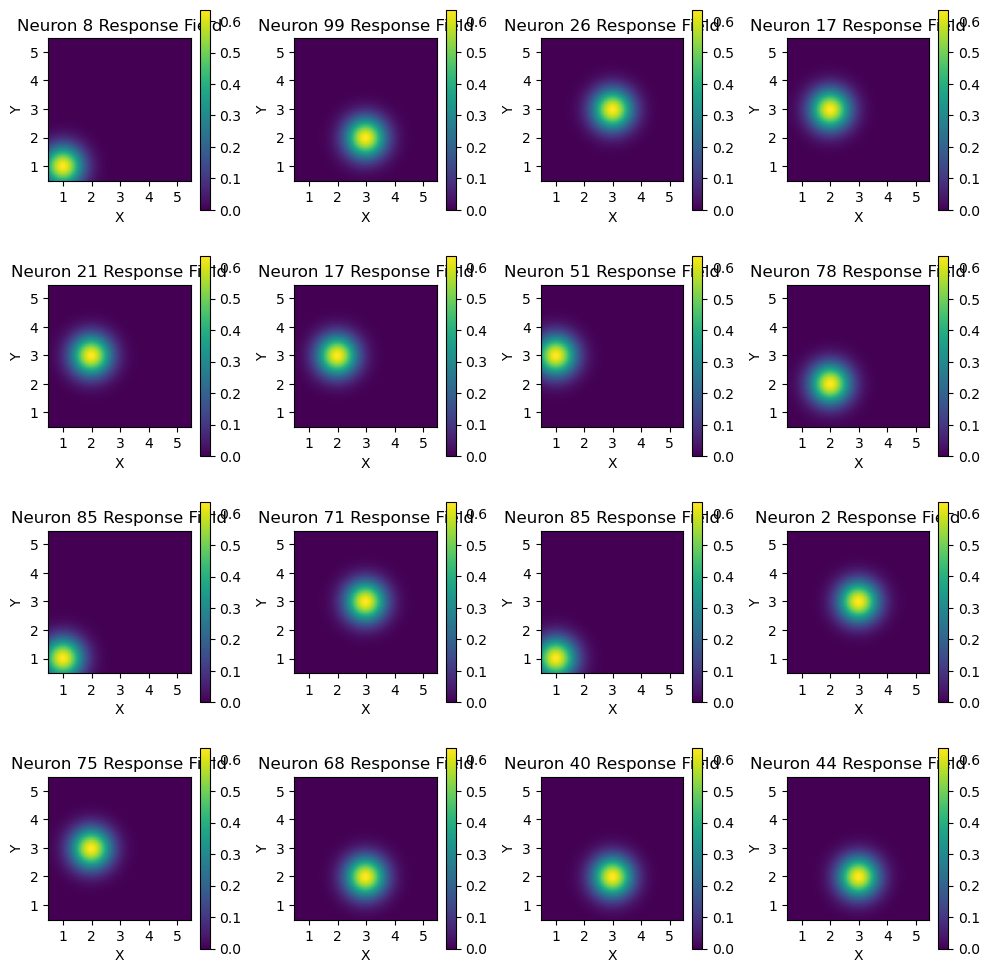

In [209]:
# Part 3: Place fields and neural activity
linker = {
    1: np.array([[1,1], [2,2], [4,4], [5,5]]),
    2: np.array([[1,5], [2,4], [4,2], [5,1]])
}

neurons, pf, randfract, frame_switch = 100, 1, 1, 2

neuron_matrix = make_neuron_activity(neurons, pf, randfract, linker, frame_switch,n_unique_axisloc,0)

fig,axes = plt.subplots(4,4,figsize=(10, 10))
for k,ax in enumerate(axes.flatten()):
    plot_neuron_responsefield(np.random.randint(neurons), neuron_matrix,fig=fig,ax=ax)
    ax.set_xticks(np.linspace(10, 90, 5))
    ax.set_xticklabels(range(1, 6))
    ax.set_yticks(np.linspace(10, 90, 5))
    ax.set_yticklabels(range(1, 6))
fig.tight_layout()
plt.show()



In [200]:
neural_activity_x.shape

(4, 100)

In [215]:
stimlocs

array([[-2, -2],
       [-2, -1],
       [-2,  1],
       [-2,  2],
       [-1, -2],
       [-1, -1],
       [-1,  1],
       [-1,  2],
       [ 1, -2],
       [ 1, -1],
       [ 1,  1],
       [ 1,  2],
       [ 2, -2],
       [ 2, -1],
       [ 2,  1],
       [ 2,  2]])

c:\Users\liangz\miniconda3\envs\piratefmri\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


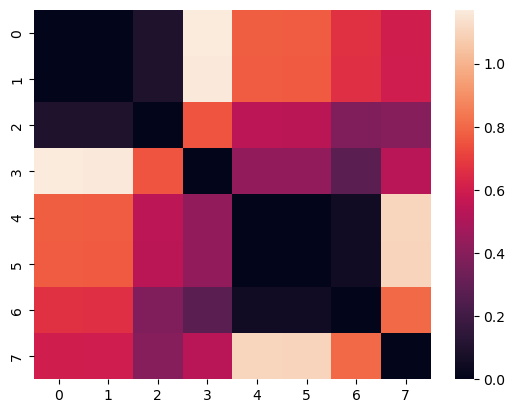

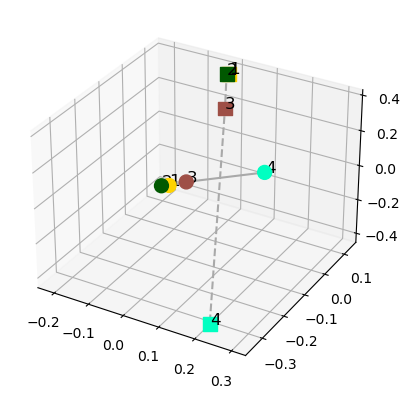

In [217]:
# Part 4: Neural activity similarity
x, y = np.meshgrid(unique_axislocs, unique_axislocs)
stimlocs = np.hstack([squelch(x), squelch(y)])

activity = np.zeros((n_unique_axisloc,n_unique_axisloc, neurons, pf))

#rs = random.randint(0,10000000)
#print(rs)
neuron_matrix = make_neuron_activity(neurons, pf, randfract, linker, frame_switch,n_unique_axisloc,0)

for idx_x,sx in enumerate(unique_axislocs):
    for idx_y,sy in enumerate(unique_axislocs):
        stimlocs[idx_x * n_unique_axisloc + idx_y] = [sx, sy]
        for n in range(neurons):
            for f in range(pf):
                activity[idx_x,idx_y, n, f] = multivariate_normal.pdf([sx, sy], mean=neuron_matrix[n][f], cov=[[0.5, 0], [0, 0.5]])

activity[activity < np.quantile(activity, 0.5)] = 0
neural_activity_5 = np.sum(activity, axis=3)

neural_activity_x = np.mean(neural_activity_5, axis=1)
neural_activity_y = np.mean(neural_activity_5, axis=0)

cos_x = pairwise_distances(neural_activity_x, metric='correlation')
cos_y = pairwise_distances(neural_activity_y, metric='correlation')

neural_activity_10 = np.vstack([neural_activity_x, neural_activity_y])
rdm = pairwise_distances(neural_activity_10, metric='correlation')
mds = MDS(n_components=3, dissimilarity='precomputed').fit_transform(rdm)

sns.heatmap(rdm)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(mds[:n_unique_axisloc, 0], mds[:n_unique_axisloc, 1], mds[:n_unique_axisloc, 2], marker='o', facecolors=colz, edgecolors=None, s=100,alpha=1)
ax.plot3D(mds[:n_unique_axisloc, 0], mds[:n_unique_axisloc, 1], mds[:n_unique_axisloc, 2],'-', color='darkgrey')

ax.scatter(mds[n_unique_axisloc:, 0], mds[n_unique_axisloc:, 1], mds[n_unique_axisloc:, 2], marker='s', facecolors=colz, edgecolors=None, s=100,alpha=1)
ax.plot3D(mds[n_unique_axisloc:, 0], mds[n_unique_axisloc:, 1], mds[n_unique_axisloc:, 2], '--', color='darkgrey')
#plt.axis('off')


for k in range(n_unique_axisloc):
    ax.text(*mds[k], str(k+1), fontsize=12)
    ax.text(*mds[k+n_unique_axisloc], str(k+1), fontsize=12)

plt.show()

c:\Users\liangz\miniconda3\envs\piratefmri\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


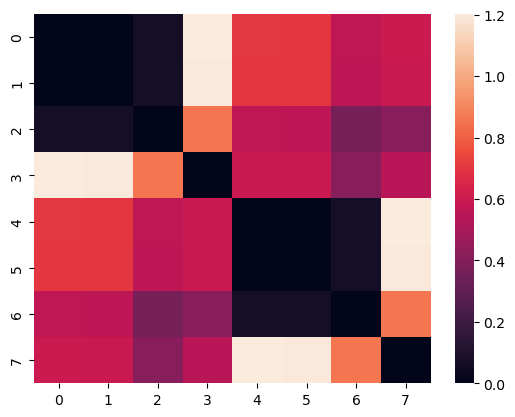

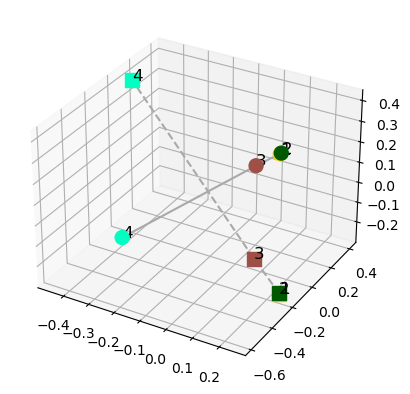

In [218]:
# Part 4: Neural activity similarity
x, y = np.meshgrid(unique_axislocs, unique_axislocs)
stimlocs = np.hstack([squelch(x), squelch(y)])

activity = np.zeros((n_unique_axisloc,n_unique_axisloc, neurons, pf))

#rs = random.randint(0,10000000)
#print(rs)
n_sim =100
neural_activities = []
neural_rdms = []
for rs in range(n_sim):
    print(rs)
    # make the neuron activity matrix
    # this is the same as the one used to generate the place fields
    # but we can use different random seeds to generate different activity patterns
    neuron_matrix = make_neuron_activity(neurons, pf, randfract, linker, frame_switch,n_unique_axisloc,rs+1646)

    for idx_x,sx in enumerate(unique_axislocs):
        for idx_y,sy in enumerate(unique_axislocs):
            stimlocs[idx_x * n_unique_axisloc + idx_y] = [sx, sy]
            for n in range(neurons):
                for f in range(pf):
                    activity[idx_x,idx_y, n, f] = multivariate_normal.pdf([sx, sy], mean=neuron_matrix[n][f], cov=[[0.5, 0], [0, 0.5]])

    activity[activity < np.quantile(activity, 0.5)] = 0
    neural_activity_5 = np.sum(activity, axis=3)

    neural_activity_x = np.mean(neural_activity_5, axis=1)
    neural_activity_y = np.mean(neural_activity_5, axis=0)

    cos_x = pairwise_distances(neural_activity_x, metric='correlation')
    cos_y = pairwise_distances(neural_activity_y, metric='correlation')

    neural_activity_10 = np.vstack([neural_activity_x, neural_activity_y])
    rdm = pairwise_distances(neural_activity_10, metric='correlation')

    neural_activities.append(neural_activity_10)
    neural_rdms.append(rdm)

mds = MDS(n_components=3, dissimilarity='precomputed').fit_transform(np.mean(neural_rdms, axis=0))

sns.heatmap(np.mean(neural_rdms, axis=0))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(mds[:n_unique_axisloc, 0], mds[:n_unique_axisloc, 1], mds[:n_unique_axisloc, 2], marker='o', facecolors=colz, edgecolors=None, s=100,alpha=1)
ax.plot3D(mds[:n_unique_axisloc, 0], mds[:n_unique_axisloc, 1], mds[:n_unique_axisloc, 2],'-', color='darkgrey')

ax.scatter(mds[n_unique_axisloc:, 0], mds[n_unique_axisloc:, 1], mds[n_unique_axisloc:, 2], marker='s', facecolors=colz, edgecolors=None, s=100,alpha=1)
ax.plot3D(mds[n_unique_axisloc:, 0], mds[n_unique_axisloc:, 1], mds[n_unique_axisloc:, 2], '--', color='darkgrey')
#plt.axis('off')


for k in range(n_unique_axisloc):
    ax.text(*mds[k], str(k+1), fontsize=12)
    ax.text(*mds[k+n_unique_axisloc], str(k+1), fontsize=12)

plt.show()